# Example notebook for the evolution of the axion density from lepton-flavour violating tau decays

In this notebook we are going to study the cosmological production of axions from flavour-violating tau decays to muons and axions in the hot plasma of the early Universe

\begin{equation}
\tau \rightarrow \mu + a
\end{equation}

using the classical **number density Boltzmann equation approach (nBE)**, which assumes that the axions are always in kinetic equilibrium with the plasma, and the more general **full phase-space density Boltzmann equation (fBE)** approach. Both of these approaches are implemented in the *PyBolt* package. 

The full Boltzmann equation defines the evolution in $x = m/T$ (with $T$ being the temperature of the Universe) of the axion (reduced) momentum $q = p/T$ distribution function $f(x,q)$ in the expanding Universe and in general is a linear partial (integro-)differential equation that can be written as follows

\begin{equation}
\tilde{H} (x \partial_x - \tilde{g} q \partial_q) \, f(x,q) = C[f_a] \, ,
\end{equation}
where $C[f_a]$ is the collision integral and $\tilde{H} = H/(1+\tilde{g})$ is the Hubble parameter divided by 

\begin{equation}
1 + \tilde{g} = 1 + \frac{1}{3} \frac{d\ln h_s}{d\ln x} \, 
\end{equation}
with $h_s$ being the effective number of entropy degrees of freedom. 

The number density equation is described below in the corresponding section.

See also the following [article](https://arxiv.org/abs/2410.18186) for more details.

## Importing libraries

We start with importing the necessary libraries. The first two are the standard Python libraries. We use only one method from the **cosmology** library that we need for the solution of the number density equation (nBE) for axions. Finally, the **fBE_solver** is the main library for the tools provided by the *PyBolt* package.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from cosmology import Y_x_eq # equilibrium comoving density of x particles
import fBE_solver as fBE

## Particle physics parameters and quantities

Defining the physics for the lepton-flavour violating tau decay to muon and axion.

Everything in the cell below can be arbitrary and is provided by the user in their code in any manner. Some parameters are further used in creating a model. 

In [2]:
# The mass of the tau lepton
m_tau = 1.776  # GeV
# The mass of the muon
m_mu = 0.10565  # GeV
# Mass of the axion
mDM = 1.0e-10 # GeV
# Ratio of the two masses
mu = m_mu/m_tau

# Number of axion degrees of freedom
g_x = 1.0
# Number of tau dofsoptions
g_tau = 2.0
# Number of muon dofs
g_mu = 2.0

# Coupling of axion to 
yMDx = 1/(4E+8) # corresponds to the PQ symmetry breaking scale f_a = 4e+8 GeV

# Decay width
Gamma = yMDx**2*m_tau**3*(1-mu**2)**3/64/np.pi # GeV
# Amplitude squared for the decay
Msquared = yMDx**2*m_tau**4*(1 - mu**2)**2/4 # GeV^2

## Creating the evolution model and processes

Creating an instance of the **Model class** that contains parameters and methods to trace the evolution of the axion phase-space density. 
- The first argument is the mass of the heaviest particle $M$ in the reactions that we study (only tau decay in this case) -- this sets the characteristic temperature scale and defines the variable $x = M/T$ which grows in the same direction as the cosmological time.
- The second argument is the mass of the DM candidate (axion).
- The third one is the number of DM degrees of freedom.
- The fourth parameter is the spin type of the DM particle, which can be 'b' (boson), 'f' (fermion) or 'm' (classical particle that obeys Maxwell-Boltzmann statistics).

Check the fBE_solver library for other parameters and class methods.

In [3]:
AxionModel = fBE.Model(m_tau,mDM,g_x,'b')

Creating an instance of the **DecayToX class**, which defines the rate and collision integral for the particular type of processes (2-body decays to a massless particle)

- The first argument is the mass of the decaying particle (tau)
- The second argument is the mass of the daugther particle other than the DM candidate (muon)
- The third argument is the number of degrees of freedom of the decaying particle
- The fourth - is the amplitude squared
- The final argument is the decay width

In [4]:
TauDecay = fBE.DecayToX(m_tau,m_mu,g_tau,Msquared,Gamma)

Defining the grid of $x = m_{\tau}/T$ and $q = p/T$ values and assigning it to the model

In [5]:
N_x = 1000 # number of x points
N_q = 200 # number of q points
xstart = 1.0  # starting x value
xfin = 20.0 # final x value

qin = 0.0001 # smallest q value
qend = 20. # biggest q value

# Creating vectors of linearly distributed values of x and q
x_lin = np.linspace(xstart,xfin,N_x)
q_lin = np.linspace(qin,qend,N_q)

# Assigning the grid (of x and q) to the model
AxionModel.changeGrid(x_lin,q_lin)

Now we add the **collision term** to our Model to be able to solve the corresponding fBE for the axion. 

We use the method ```addCollisionTerm``` from the Model class to assign a collision integral for the decay process, which is a function of 4 variables - $x, q, f(x,q)$ and $f_{\rm eq}(x,q)$, where $f$ is the actual axion distribution function and $f_{\rm eq}$ is the equilibrium one. 

The idea behind "addCollisionTerm" is to add many collision integrals created from different process classes or even arbitrary functions of $(x,q,f,f_{\rm eq})$ to fully define the evolution model with all the necessary processes. 

For the current model we add only one collision integral for the tau decay.

In [6]:
AxionModel.addCollisionTerm(TauDecay.collisionTerm)

## Solving fBE

Defining the initial condition for the fBE - $f_0$, which is just $0$ (an array of the same size as $q$) 

In [7]:
f0 = np.zeros_like(q_lin)

Setting the fBE numerical solver options (method, absolute and relative tolerances) and starting the fBE solver with the given initial distribution and solver options (see [solve_ivp](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html) method description for more possible options).

The ```solve_fBE``` method uses the grid of $x$ and $q$ values defined above and returns an array of the distribution function $f$ for a given grid. 

In [8]:
# fBE solver options
solver_options = {
    'method': 'RK45', # Explicit Runge-Kutta method of order 5(4)
    'atol': 1e-8,   # Absolute tolerance
    'rtol': 1e-3    # Relative tolerance
}

AxionModel.solve_fBE(f0,solver_options)

fBE solved in 0.06 seconds


```getSolution()``` method gives you the resulting distribution function. Below we can check the shape of the solution array, for example

In [9]:
AxionModel.getSolution().shape

(1000, 200)

Plot a kymograph of the solution using the built-in method of the Model class

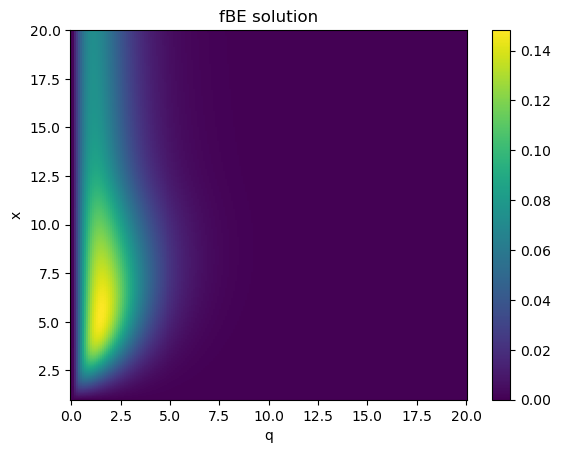

In [10]:
AxionModel.plot2D()

Let's compute the corresponding comoving number density $Y = n/s$ from the distribution function, where $n$ is the particle number density and $s$ is the entropy density. To do that we use the ```getDensity()``` method that creates an array of the same size as $x$

In [11]:
x = AxionModel.getX() # returns a vector of x values
Y = AxionModel.getDensity()

## Solving nBE

Now let's compute also the comoving density from the **classical nBE approach** (that relies on the assumption of kinetic equilibrium) and compare it with the fBE solution. 

For that we have a method of the Model class ```solve_nBE``` that takes an array of $x$ values, the rate of the comoving density evolution $R(x,Y)$ and the initial comoving density $Y_0$ ($0$ in our case).

The nBE has the following form

\begin{equation}
\frac{dY}{dx} = \frac{R(x,Y)}{\tilde{H}s(x) \, x} \, ,
\end{equation}
where $\tilde{H} = H/(1+\tilde{g})$ is the Hubble parameter divided by the factor that takes into account the change of the entropy degrees of freedom. 

The rate $R(x,Y)$ can be obtained as a method of the process class.

In [12]:
nBE_rate = TauDecay.rate
Y_nBE = AxionModel.solve_nBE(x,nBE_rate,0.0) # solve the standard Boltzmann ODE to compare the results

2024-11-05 15:22:10,678 - Starting solve_nBE...
2024-11-05 15:22:10,703 - solve_nBE completed in 0.02 seconds


## Results

Now we can plot the two solutions and compare them. We also plot the equilibrium comoving density curve. 

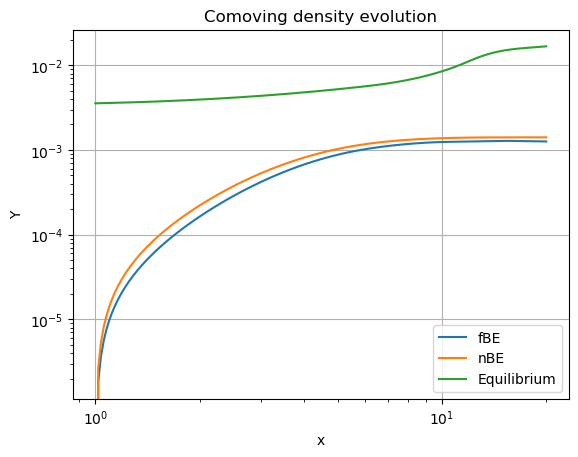

In [13]:
plt.figure
plt.loglog(x,Y) # fBE
plt.loglog(x,Y_nBE) #nBE
plt.loglog(x,Y_x_eq(m_tau/x)) # equilibrium density
plt.grid()
plt.xlabel('x')
plt.ylabel('Y')
plt.title('Comoving density evolution')
plt.legend(["fBE", "nBE","Equilibrium"], loc="lower right")
plt.show()

Here we print the values of the comoving relic densities provided by the two approaches

In [14]:
# Final values of the density returned by the two methods
print('Y_fBE = ',Y[-1])
print('Y_nBE = ',Y_nBE[-1])

Y_fBE =  0.001260458917124297
Y_nBE =  0.001410069658797526


We can also plot the distribution function at the end of the evolution using the built-in method and compare it with the equilibrium one. 

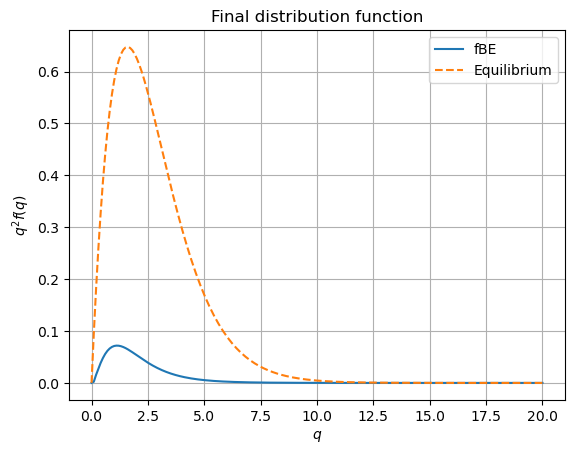

In [15]:
AxionModel.plotFinalPDF()